In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

powerfactory_path = r'C:\Program Files\DIgSILENT\PowerFactory 2020 SP4\Python\3.8'
if powerfactory_path not in sys.path:
    sys.path.append(powerfactory_path)
import powerfactory as %pfile

In [2]:
def print_load_flow_results():
    generators = app.GetCalcRelevantObjects('*.ElmSym')
    lines = app.GetCalcRelevantObjects('*.ElmLne')
    buses = app.GetCalcRelevantObjects('*.ElmTerm')
    loads = app.GetCalcRelevantObjects('*.ElmLod')
    
    print('Generators:')   
    for i,gen in enumerate(generators):
        P = gen.GetAttribute('c:p')
        Q = gen.GetAttribute('c:q')
        loading = gen.GetAttribute('c:loading')
        print(f'[{i+1:02d}] {gen.loc_name}: P = {P:.2f} MW, Q = {Q:.2f} MVAR, loading = {loading:.1f}%.')
        
    print('Lines:')
    for i,line in enumerate(lines):
        loading = line.GetAttribute('c:loading')
        maxload = line.GetAttribute('c:maxload')
        print(f'[{i+1:02d}] {line.loc_name}: loading = {loading:.1f}/{maxload:.1f}%.')
        
    print('Buses:')
    for i,bus in enumerate(buses):
        voltage = bus.GetAttribute('m:u')
        phase = bus.GetAttribute('m:phiu')
        print(f'[{i+1:02d}] voltage @ {bus.loc_name}: {voltage:.2f} pu ({phase:.2f} deg).')
        
    print('Loads:')
    for i,load in enumerate(loads):
        P = load.GetAttribute('m:Psum:bus1')
        Q = load.GetAttribute('m:Qsum:bus1')
        print(f'[{i+1:02d}] {load.loc_name}: P = {P:.2f} MW, Q = {Q:.2f} MVAR.')

In [3]:
app = pf.GetApplication()
if app is None:
    raise Exception('Cannot get PowerFactory application')
else:
    print('Successfully obtained PowerFactory application.')

Successfully obtained PowerFactory application.


In [4]:
project_name = 'PythonTutorial_Introduction'
err = app.ActivateProject(project_name)
if err:
    raise Exception(f'Cannot activate project {project_name}')
print(f'Successfully activated project {project_name}.')

Successfully activated project PythonTutorial_Introduction.


In [5]:
project = app.GetActiveProject()
if project is None:
    raise Exception('Cannot get active project')
print('Successfully obtained active project.')

Successfully obtained active project.


In [6]:
project_folders = {}
for folder_name in ('study',):
    project_folders[folder_name] = app.GetProjectFolder(folder_name)
    if project_folders[folder_name] is None:
        raise Exception(f'No folder "{folder_name}" present')
    print(f'Successfully obtained folder "{folder_name}".')

Successfully obtained folder "study".


In [7]:
study_case_name = 'LoadFlow'
if '.IntCase' not in study_case_name:
    study_case_name += '.IntCase'
study_case = project_folders['study'].GetContents(study_case_name)[0]
err = study_case.Activate() # don't know why this returns 1
# if err:
#     raise Exception(f'Cannot activate study case {study_case_name}')
print(f'Successfully activated study case {study_case_name}.')

Successfully activated study case LoadFlow.IntCase.


In [8]:
load_flow = app.GetFromStudyCase('ComLdf')

In [9]:
err = load_flow.Execute()
if err:
    raise Exception(f'Cannot run load flow')
print_load_flow_results()

Generators:
[01] Synchronous Machine: P = 50.00 MW, Q = 0.00 MVAR, loading = 62.5%.
Lines:
[01] Line to Load: loading = 106.4/100.0%.
[02] Line to Static Generator: loading = 49.4/100.0%.
[03] Line to Synchronous Machine: loading = 61.3/100.0%.
Buses:
[01] voltage @ Terminal External Grid: 1.02 pu (0.00 deg).
[02] voltage @ Terminal Load: 1.00 pu (-2.48 deg).
[03] voltage @ Terminal Static Generator: 1.04 pu (0.93 deg).
[04] voltage @ Terminal Synchronous Machine: 1.05 pu (1.43 deg).
Loads:
[01] General Load 1: P = 100.00 MW, Q = 0.00 MVAR.
[02] General Load 2: P = 20.00 MW, Q = 0.00 MVAR.


In [10]:
load = app.GetCalcRelevantObjects('General Load 1.ElmLod')[0]
line_to_load = app.GetCalcRelevantObjects('Line to Load.ElmLne')[0]
P = np.r_[10. : 101. : 5.]
loading = np.zeros(P.size)
for i,p in enumerate(P):
    load.plini = p
    err = load_flow.Execute()
    if err:
        raise Exception('Cannot run load flow for P = {p:.2f} MW.')
    loading[i] = line_to_load.GetAttribute('c:loading')

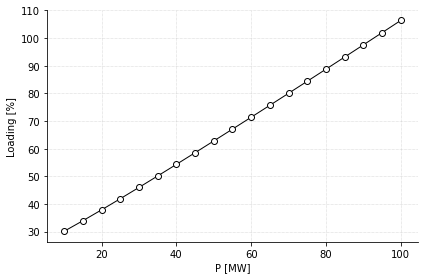

In [11]:
fig,ax = plt.subplots(1, 1)
ax.plot(P, loading, 'ko-', lw=1, markerfacecolor='w')
ax.set_xlabel('P [MW]')
ax.set_ylabel('Loading [%]')
for side in 'right','top':
    ax.spines[side].set_visible(False)
ax.grid(which='major', axis='both', lw=0.5, ls=':')
fig.tight_layout()